In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt


## Data Preprocessing

In [7]:
TRAINING_DIR = "dataset/"

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=126,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    subset='training')


Found 2188 images belonging to 3 classes.


In [23]:
validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=126,
                                                        class_mode='categorical',
                                                        target_size=(150, 150),
                                                        subset='validation')


Found 2188 images belonging to 3 classes.


## Create Model

In [10]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


9420800/9406464 [==============================] - 1s 0us/step


In [19]:
x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [20]:
int_lr = 1e-4
num_epochs = 20

optimizer = tf.optimizers.Adam(lr=int_lr, decay=int_lr/num_epochs)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Training

In [21]:
H = model.fit(train_generator,
              steps_per_epoch=20,
              epochs=num_epochs,
              validation_data=validation_generator,
              validation_steps=3)

Epoch 1/20


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[0,3] labels_size=[126,3]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-21-24ce7f0fb484>:1) ]] [Op:__inference_train_function_11841]

Function call stack:
train_function


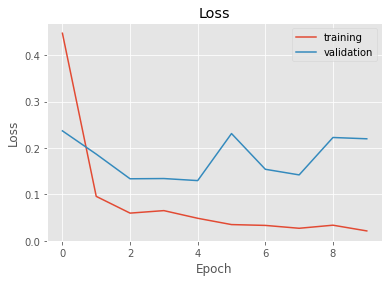

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


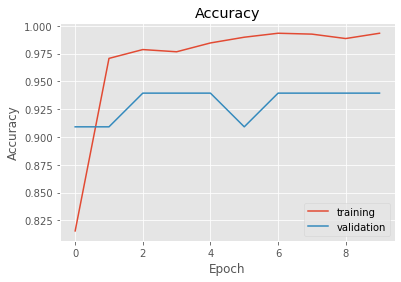

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
